In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy

In [2]:
# 1. Paths
data_dir = r"./IfcTrainTest"  # needs to have more than one class in the folder

In [3]:
# 2. Image Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
# 3. Dataset & DataLoader
generator = torch.Generator().manual_seed(42)
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.6, 0.1, 0.3], generator)

In [5]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [6]:
# 4. Simple CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # RGB = 3 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, len(dataset.classes))  # output = number of classes
        )

    def forward(self, x):
        y = self.conv_layer(x)
        z = self.fc_layer(y)
        return z

In [7]:
# 5. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
def train_one_epoch(dataloader):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

In [9]:
def validate(dataloader):
    model.eval()
    accuracy = MulticlassAccuracy(num_classes=len(dataset.classes))

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
    
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())

    all_preds = torch.hstack(all_preds)
    all_labels = torch.hstack(all_labels)
    acc = accuracy(all_preds, all_labels)
    print(f"Val. Accuracy: {acc}")

    return all_preds, all_labels

In [10]:
# 6. Training Loop

for epoch in range(5):  # short training for testing 
    train_one_epoch(train_dataloader)
    validate(val_dataloader)

Epoch 1, Loss: 42.1224
Val. Accuracy: 0.6901165843009949
Epoch 2, Loss: 28.7000
Val. Accuracy: 0.8086634278297424
Epoch 3, Loss: 21.3003
Val. Accuracy: 0.8397030830383301
Epoch 4, Loss: 15.3881
Val. Accuracy: 0.8516335487365723
Epoch 5, Loss: 12.8795
Val. Accuracy: 0.8704602718353271


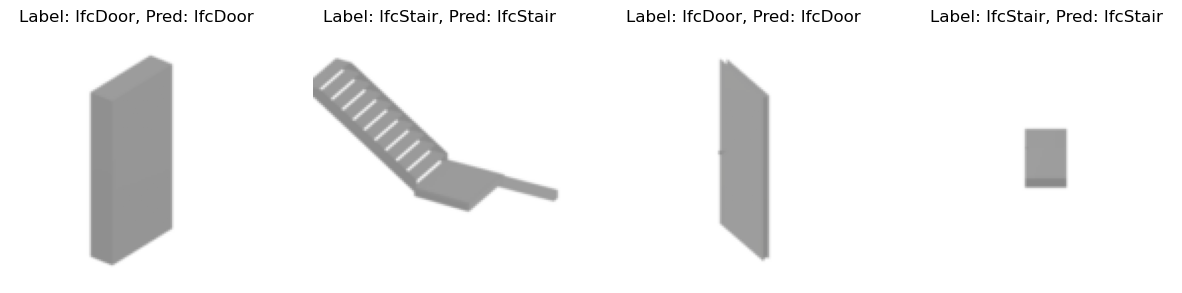

In [11]:
# 7. Visualizing Predictions (Optional)
model.eval()
with torch.no_grad():
    inputs, labels = next(iter(test_dataloader))
    inputs = inputs.to(device)
    outputs = model(inputs)
    preds = torch.argmax(outputs, dim=1)

    plt.figure(figsize=(15, 4))
    for i in range(4):
        img = inputs[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(f"Label: {dataset.classes[labels[i]]}, Pred: {dataset.classes[preds[i]]}")
        plt.axis("off")
    plt.show()

Val. Accuracy: 0.8680611848831177


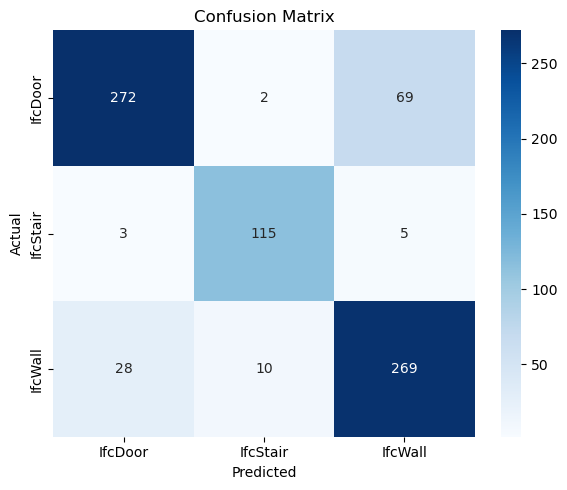

In [12]:
# 8. Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

all_preds, all_labels = validate(test_dataloader)
all_preds, all_labels = all_preds.numpy(), all_labels.numpy()

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Class names from dataset
class_names = dataset.classes

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()